In [ ]:
!nvidia-smi

Tue Apr 20 05:29:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [ ]:
def conv_block(input_img, convs, skip=True):
	x = input_img
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv[2] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) 
		x = Conv2D(conv[0],
				   conv[1],
				   strides=conv[2],
				   padding='valid' if conv[2] > 1 else 'same',
				   name='Conv_' + str(conv[5]),
				   use_bias=False if conv[3] else True)(x)
		if conv[3]: x = BatchNormalization(epsilon=0.001, name='BNorm_' + str(conv[5]))(x)
		if conv[4]: x = LeakyReLU(alpha=0.1, name='Leaky_Relu_' + str(conv[5]))(x)
	return add([skip_connection, x]) if skip else x

In [ ]:
def make_yolov3_model():
	img_in = Input(shape=(None, None, 3))
	x = conv_block(img_in, [[32, 3, 1,True, True,0],[64, 3, 2, True, True, 1],[32, 1, 1, True, True, 2],[64, 3, 1, True, True, 3]])
	x = conv_block(x, [[128, 3, 2,True, True,5],[64, 1, 1, True, True, 6],[128, 3, 1, True, True, 7]])
	x = conv_block(x, [[64, 1, 1, True, True, 9],[128, 3, 1, True, True, 10]])
	x = conv_block(x, [[256, 3, 2, True, True, 12],[128, 1, 1, True, True, 13],[256, 3, 1, True, True, 14]])
	for i in range(7):
		x = conv_block(x, [[128, 1, 1, True, True, 16+i*3],[256, 3, 1, True, True, 17+i*3]])
	skip_36 = x
	x = conv_block(x, [[512, 3, 2, True, True, 37],[256, 1, 1, True, True, 38],[512, 3, 1, True, True, 39]])
	for i in range(7):
		x = conv_block(x, [[256, 1, 1, True, True, 41+i*3],[512, 3, 1, True, True, 42+i*3]])
	skip_61 = x
	x = conv_block(x, [[1024, 3, 2, True, True, 62],[512, 1, 1, True, True,63],[1024, 3, 1, True, True, 64]])
	for i in range(3):
		x = conv_block(x, [[512, 1, 1, True, True, 66+i*3],[1024, 3, 1, True, True, 67+i*3]])
	x = conv_block(x, [[512, 1, 1, True, True, 75],[1024, 3, 1, True, True, 76],[512, 1, 1, True, True, 77],[1024, 3, 1, True, True, 78],[512, 1, 1, True, True, 79]], skip=False)
	yolo_82 = conv_block(x, [[1024, 3, 1, True, True, 80],
							  [18, 1, 1, False, False, 81]], skip=False)
	x = conv_block(x, [[256, 1, 1, True, True, 84]], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	x = conv_block(x, [[256, 1, 1, True, True, 87],[512, 3, 1, True, True, 88],[256, 1, 1, True, True, 89],[512, 3, 1, True, True, 90],[256, 1, 1, True, True, 91]], skip=False)
	yolo_94 = conv_block(x, [[512, 3, 1, True, True, 92],[18, 1,  1, False, False, 93]], skip=False)
	x = conv_block(x, [[128, 1, 1, True, True, 96]], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	yolo_106 = conv_block(x, [[128, 1, 1, True, True, 99],[256, 3, 1, True, True, 100],[128, 1, 1, True, True, 101],[256, 3, 1, True, True, 102],[128, 1, 1, True, True, 103],[256, 3, 1, True, True, 104],[18, 1, 1, False, False, 105]], skip=False)
	model = Model(img_in, [yolo_82, yolo_94, yolo_106])
	return model



In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('Conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('BNorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size)
					gamma = self.read_bytes(size)
					mean  = self.read_bytes(size)
					var   = self.read_bytes(size) 
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0


In [ ]:
model = make_yolov3_model()

In [ ]:
weight_reader = WeightReader('/content/drive/MyDrive/yolov3-helmet.weights')

In [ ]:
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

In [ ]:
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    
    return image, width, height

In [ ]:
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w 
			y = (row + y) / grid_h 
			w = anchors[2 * b + 0] * np.exp(w) / net_w 
			h = anchors[2 * b + 1] * np.exp(h) / net_h
      
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

In [ ]:
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

In [ ]:
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
	return v_boxes, v_labels, v_scores

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
  data = pyplot.imread(filename)
  pyplot.imshow(data)
  ax = pyplot.gca()

  for i in range(len(v_boxes)):
    box = v_boxes[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
    label = "%s (%.3f)" % (v_labels[i], v_scores[i])
    pyplot.text(x1, y1, label, color='blue')

  
  pyplot.show()

In [ ]:
input_w, input_h = 416, 416
test_img = 'test.jpg'

image, image_w, image_h = load_image_pixels(test_img, (input_w, input_h))

In [ ]:
yhat = model.predict(image)
print([a.shape for a in yhat])

[(1, 13, 13, 18), (1, 26, 26, 18), (1, 52, 52, 18)]


In [ ]:

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

In [ ]:
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [ ]:
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [ ]:
do_nms(boxes, 0.5)

In [ ]:
labels = ["helmet"]

In [ ]:
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

In [ ]:
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])

helmet 83.47921371459961
helmet 72.46578335762024
helmet 83.99930596351624
helmet 75.8837342262268
helmet 91.26142263412476


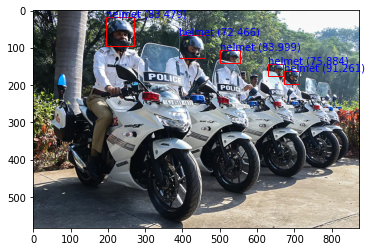

In [ ]:
draw_boxes(test_img, v_boxes, v_labels, v_scores)